In [1]:
library(variableStars)
library(data.table)
library(ggplot2)
library(RColorBrewer)
library(plotly)
library(keras)
library(plotly)
library(abind)
library(fields)


Attaching package: 'plotly'

The following object is masked from 'package:ggplot2':

    last_plot

The following object is masked from 'package:stats':

    filter

The following object is masked from 'package:graphics':

    layout

Loading required package: spam
Loading required package: dotCall64
Loading required package: grid
Spam version 2.2-0 (2018-06-19) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: 'spam'

The following objects are masked from 'package:base':

    backsolve, forwardsolve

Loading required package: maps
See www.image.ucar.edu/~nychka/Fields for
 a vignette and other supplements. 


### Read processed files and create big matrix with all rows

In [2]:
setwd("~/Downloads/data2/")
system("find . -type f -name \"*.log\" -print0 | xargs -0 cat > ALL.data")
df_all <- data.frame(fread("ALL.data", sep=",", header = F), stringsAsFactors=F)
dim(df_all)
df_all <- df_all[complete.cases(df_all),]
dim(df_all)

[1] 506826   1626

[1] 506560   1626

### Experiment parameters

In [3]:
# Resolution for target frequency [0-100]
input_resolution <- 0.25
output_resolution <- 1.0

# Input dimension
cuts_breaks <- c(-Inf, seq(0, 101, resolution), Inf)
input_dim <- length(cuts_breaks) - 1

# Output dimension
num_classes <-
  length(seq(
    from = 0.0,
    to = 9 / 0.0864,
    by = 1
  )) # Buckets of possible classes

### Matrix creation from data

In [4]:
rows <- dim(df_all)[1]
cols <- (dim(df_all)[2] - 2) / 4
dimensions <- 3 # Number of channels
X <- array(0, c(rows, cols, dimensions))
# Y train is a 1D matrix with rows and targets
Y <- matrix(0, nrow = rows, ncol = num_classes)
ind_data <- seq(from=1,to=rows)

In [5]:
# Reshape dataframe to matrix slices
X[ind_data, , 1] <- as.matrix(df_all[ind_data, 1:406])
X[ind_data, , 2] <- as.matrix(df_all[ind_data, 406:((406 * 2) - 1)])
X[ind_data, , 3] <- as.matrix(df_all[ind_data, (406 * 2):((406 * 3) - 1)])
#X[ind_data, , 4] <- as.matrix(df_all[ind_data, (406 * 3):((406 * 4) - 1)])
Y <- (to_categorical(df_all[ind_data, 1626:1626] / 0.0864, num_classes))

dim(X)
dim(Y)

[1] 506560    406      4

[1] 506560    163

### Check that target is not in the trainind data

In [6]:
print(paste0("Check for target 1:"))
flags <- c()
for (i in seq(from=1,to=rows)){
    flags <- c(flags, df_all[i, 1626:1626] %in% rbind(X[i,,1],X[i,,2],X[i,,3]))
}
print(table(flags))

flags <- c()
print(paste0("Check for target 2:"))
for (i in seq(from=1,to=rows)){
    flags <- c(flags, df_all[i, 1625:1625] %in% rbind(X[i,,1],X[i,,2],X[i,,3]))
}
print(table(flags))

[1] "Check for target 1:"
flags
 FALSE   TRUE 
506551      9 
[1] "Check for target 2:"
flags
 FALSE   TRUE 
506063    497 


In [ ]:
#ind_remove_no_target <- which(apply(Y,1,sum)==1)
#paste0("Removing ",length(ind_remove_no_target[ind_remove_no_target==TRUE])," rows with NO target")

#X <- X[ind_remove_no_target,,]
#Y <- Y[ind_remove_no_target,]

#dim(X)
#dim(Y)

In [7]:
stopifnot(which(is.na(Y))==FALSE)
stopifnot(which(is.na(X))==FALSE)

In [8]:
# Split train/test
smp_size <- floor(0.9 * nrow(X))
set.seed(123)
ind <- sample(seq_len(nrow(X)), size = smp_size)

# Prepare partition
x_train <- X[ind, , ]
x_test  <- X[-ind, , ]
y_train <- Y[ind, ]
y_test  <- Y[-ind, ]
# Check dims
dim(x_train)
dim(y_train)
dim(x_test)
dim(y_test)

[1] 455904    406      4

[1] 455904    163

[1] 50656   406     4

[1] 50656   163

### EDA of data

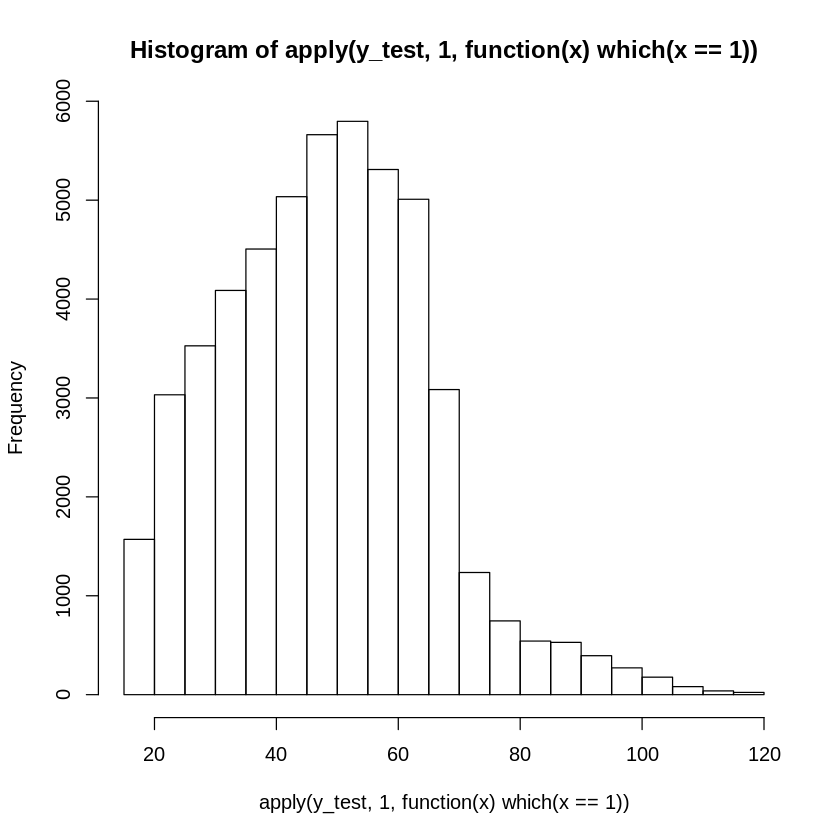

In [9]:
hist(apply(y_test,1,function(x) which(x==1)))

### Calculate class weigth

In [10]:
den <- density(apply(y_test,1,function(x) which(x==1)))

[1]   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
 [19]  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
 [37]  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
 [55]  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
 [73]  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
 [91]  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
[109] 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
[127] 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
[145] 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
[163] 162

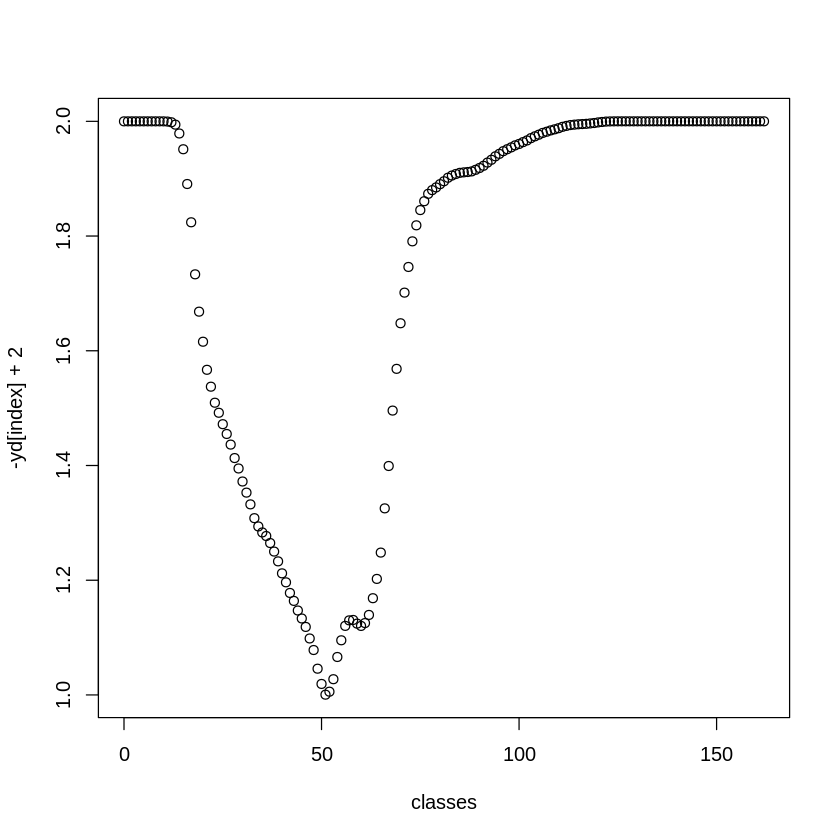

In [328]:
#classes <- seq(
#    from = 0.0,
#    to = 14 / 0.0864,
#    by = output_resolution)
#classes
    

#yd <- normalized(as.numeric(den$y))
#index <- as.numeric(lapply(classes,function(x) which.min(abs(x-den$x))))

                           
#plot(classes, -yd[index]+2)
#weight_classes <- -yd[index]+2

### NN train

In [11]:
top_8_categorical_accuracy <-
  custom_metric("rec_at_8", function(y_true, y_pred) {
    metric_top_k_categorical_accuracy(y_true, y_pred, 8)
  })
top_6_categorical_accuracy <-
  custom_metric("recat_6", function(y_true, y_pred) {
    metric_top_k_categorical_accuracy(y_true, y_pred, 6)
  })
top_4_categorical_accuracy <-
  custom_metric("rec_at_4", function(y_true, y_pred) {
    metric_top_k_categorical_accuracy(y_true, y_pred, 4)
  })
top_2_categorical_accuracy <-
  custom_metric("rec_at_2", function(y_true, y_pred) {
    metric_top_k_categorical_accuracy(y_true, y_pred, 2)
  })

In [12]:
checkpoint_dir <- "~/Downloads/test/"
if (T) {
    unlink(checkpoint_dir, recursive = TRUE)
    dir.create(checkpoint_dir)
    filepath <- file.path(checkpoint_dir, "weights.{epoch:02d}-{val_loss:.2f}.hdf5")


# Create checkpoint callback
cp_callback <- callback_model_checkpoint(
  filepath = filepath,
  save_weights_only = TRUE,
  period = 5,
  verbose = 1
)
}
    

# Create a 1d convolutional NN
model <- keras_model_sequential() %>%
  layer_separable_conv_1d(
    kernel_size = 5,
    filters = 5,
    depth_multiplier = 5,
    input_shape = c(406, 4)
  ) %>%
  layer_max_pooling_1d(pool_size = 2) %>%
  layer_separable_conv_1d(
    kernel_size = 5,
    filters = 5,
    depth_multiplier = 5,
  ) %>%
  layer_max_pooling_1d(pool_size = 2) %>%
  layer_dropout(0.2) %>%
  layer_flatten() %>%
  layer_dense(units = num_classes, activation = 'softmax')



# Configure a model for categorical classification.
model %>% compile(
  loss = "categorical_crossentropy",
  optimizer = optimizer_adadelta(lr = 0.01),
  metrics = c(
          "accuracy",
          top_2_categorical_accuracy,
          top_4_categorical_accuracy,
          top_6_categorical_accuracy,
          top_8_categorical_accuracy
        )
)
summary(model) # Plot summary

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
separable_conv1d_1 (SeparableConv1D (None, 402, 5)                  205         
________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)      (None, 201, 5)                  0           
________________________________________________________________________________
separable_conv1d_2 (SeparableConv1D (None, 197, 5)                  255         
________________________________________________________________________________
max_pooling1d_2 (MaxPooling1D)      (None, 98, 5)                   0           
________________________________________________________________________________
dropout_1 (Dropout)                 (None, 98, 5)                   0           
________________________________________________________________________________
flatten_1 (Flatten)         

In [13]:
if (T) {
# Fit model
  history <- model %>% fit(
    x_train,
    y_train,
    epochs = 700,
    batch_size =  250,
    validation_split = 0.1,
    shuffle = T,
    verbose = 2,
    callbacks = list(cp_callback) 
  )
}

In [14]:
#model %>% load_model_weights_hdf5(
#  file.path("~/Downloads/checkpointsDnuData2/weights.390-2.26.hdf5")
#)
evaluate(model, x_test, y_test)

# evaluate on delta scuti stars
#load("../../docs/GPU/X_scuti.rda")
#load("../../docs/GPU/Y_scuti.rda")
#evaluate(model, X_scuti, Y_scuti)

$loss
[1] 2.745901

$acc
[1] 0.1601785

$rec_at_2
[1] 0.2934697

$rec_at_4
[1] 0.4854509

$recat_6
[1] 0.6214071

$rec_at_8
[1] 0.7315027

In [92]:
plot(history) +
  theme_bw()

ERROR: Error in .External2(C_savehistory, file): no history available to save


### Confusion matrix

In [15]:
Y_test_hat <- predict_classes(model, x_test)
# Calculate confusion matrix
cm <- table(apply(y_test,1,which.max), Y_test_hat)
# Plot matrix
dtCM <- as.data.frame(cm)
colnames(dtCM) <- c("c1","c2","freq")
dtCM$c1 <- as.numeric(dtCM$c1)
dtCM$c2 <- as.numeric(dtCM$c2)
dtCM$freq <- as.numeric(dtCM$freq)
dim(dtCM)

[1] 9434    3

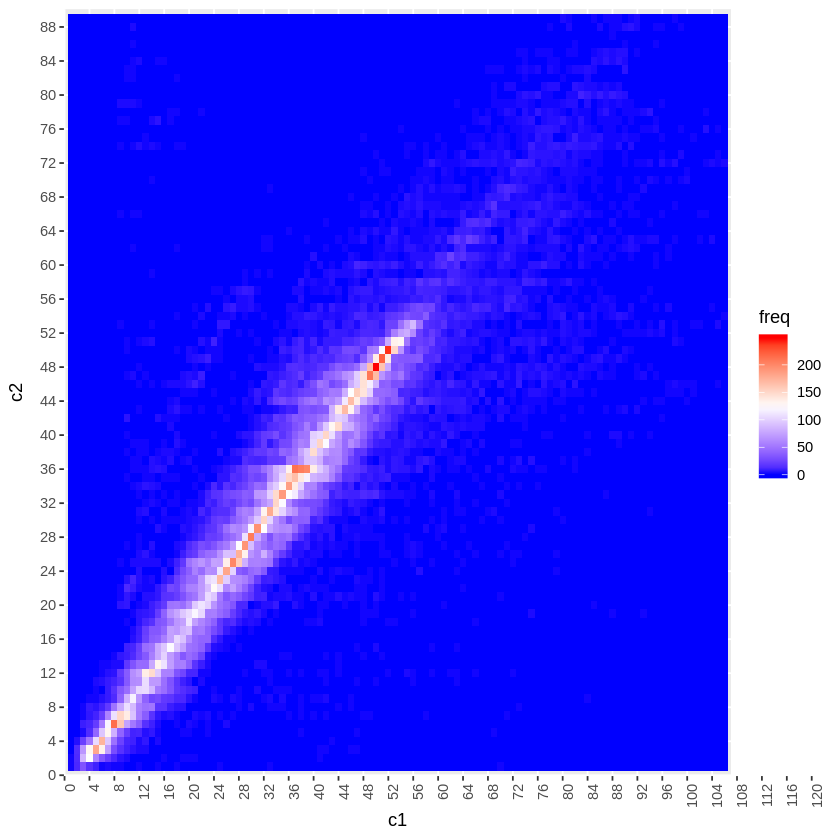

In [16]:
ggplot(data=dtCM, aes(c1, c2, fill = freq)) +
  geom_tile() +
  scale_fill_gradientn(colours=c("#0000FFFF","#FFFFFFFF","#FF0000FF"))+
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  #scale_fill_gradient(breaks=seq(from=-.5, to=4, by=.2))
  scale_x_discrete(breaks=seq(from=0,to=120,by=4), limits=seq(0,120)) +
  scale_y_discrete(breaks=seq(from=0,to=120,by=4), limits=seq(0,120)) 

### MSE error acc_at_1

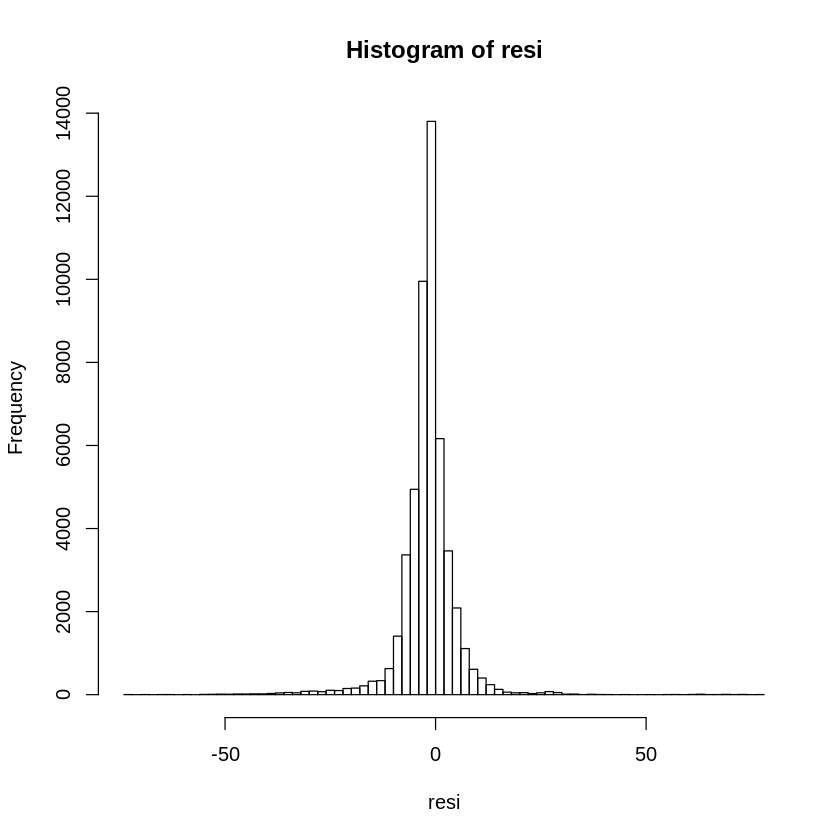


FALSE  TRUE 
 3358 47298 


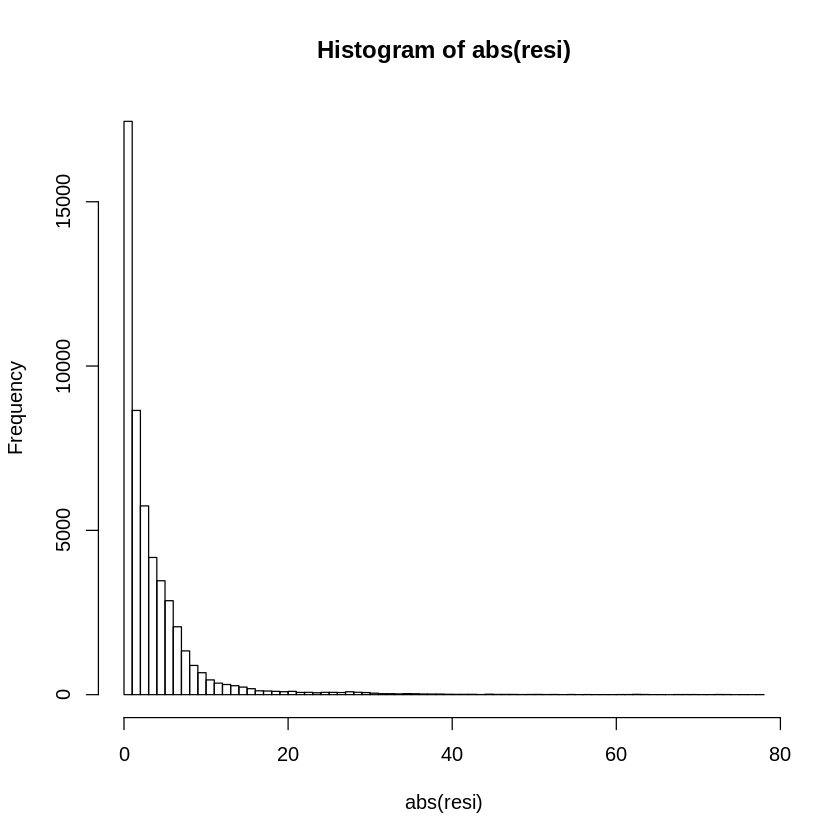

In [17]:
# Output dimension
classes <- seq(
    from = 0.1,
    to = 14 / 0.0864,
    by = output_resolution
  )


resi <- ((classes[Y_test_hat]) - (classes[apply(y_test,1,function(x) which(x==1))]))
hist(resi, breaks=100)
hist(abs(resi), breaks=100)
print(table(abs(resi)<=10))

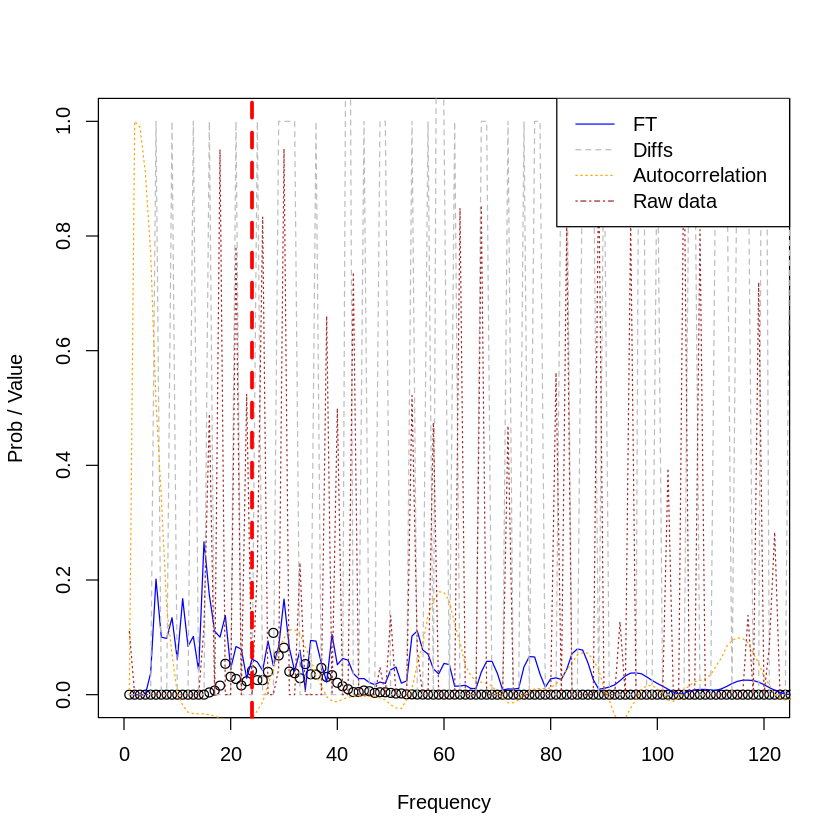

In [154]:
select_test <- 5500

y_hats <- predict(model, x_test)

plot(
  y_hats[select_test,],
  lty = 1,
  ylim = c(0, 1),
  xlim = c(0, 120),
  col = "black",
  xlab = "Frequency",
  ylab = "Prob / Value"
)


lines(x_test[select_test, , 1], lty = 1, col = "blue")
lines(x_test[select_test, , 2], lty = 2, col = "grey")
lines(x_test[select_test, , 3], lty = 3, col = "orange")
lines(x_test[select_test, , 4], lty = 3, col = "brown")

abline(
  v = which(y_test[select_test, ]==1)[1],
  col = "red",
  lwd = 3,
  lty = 2
)


legend(
  "topright",
  c("FT", "Diffs", "Autocorrelation", "Raw data"),
  lty = c(1, 2, 3, 4),
  col = c("blue", "grey", "orange", "brown")
)

### Auxiliar functions for Validation on $\delta$-scuti stars

In [1]:
trunc <-
    function(x, ..., prec = 1)
      base::trunc(x * 10 ^ prec, ...) / 10 ^ prec
  
  
  flat <- function(x) {
    return(paste0(trunc(c(x), prec = 4), collapse = ","))
  }

normalized <- function(x) {
        (x - min(x)) / (max(x) - min(x))
      }

validate_real_star <- function(data, real_dnu, real_dr, numFrequencies=30) {

    
  # Execute experiment
  result <- process(
    frequency = data$V1,
    amplitude = data$V2,
    filter = "uniform",
    gRegimen = 0,
    maxDnu = 1,
    minDnu = 15,
    numFrequencies = numFrequencies,
    dnuGuessError = -1,
    debug = F,
    processFirstRangeOnly = numFrequencies
  )
  
  
    # Save ft of diffs
  ftS <-
    stats.bin(as.numeric(result$fresAmps[[names(result$fresAmps)[1]]]$fInv),
              as.numeric(result$fresAmps[[names(result$fresAmps)[1]]]$b),
              breaks = cuts_breaks)$stats
  ft_1D <- ftS[8, 1:(length(cuts_breaks) - 1)]
  ft_1D[is.na(ft_1D)] <- 0

    diffS <-
      stats.bin(
        as.numeric(result$diffHistogram$histogram$bins),
        as.numeric(result$diffHistogram$histogram$values),
        breaks = cuts_breaks
      )$stats
    diff_2D <- diffS[8, 1:(length(cuts_breaks) - 1)]
    diff_2D[is.na(diff_2D)] <- 0
    
    # Save crosscorrelation
    cross <- stats.bin(
      as.numeric(result$crossCorrelation$index),
      as.numeric(result$crossCorrelation$autocorre),
      breaks = cuts_breaks
    )$stats
    cross_3D <- cross[8, 1:(length(cuts_breaks) - 1)]
    cross_3D[is.na(cross_3D)] <- 0
          
    # Raw information
    rawS <-
      stats.bin(as.numeric(data$V1)/0.0864,
                as.numeric(data$V2),
                breaks = cuts_breaks)$stats
    raw_1D <- rawS[8, 1:(length(cuts_breaks) - 1)]
    raw_1D[is.na(raw_1D)] <- 0
    
    # Assert all dimensions are equal
    stopifnot((length(ft_1D) == length(diff_2D)) ==
                ((length(diff_2D) == length(cross_3D)) ==
                   (
                     length(cross_3D) == length(cuts_breaks) - 1
                   )))
    

  rows <- dim(df_all)[1]
  cols <- (dim(df_all)[2] - 2) / 4
  dimensions <- 4 # Number of channels
  X <- array(0, c(1, cols, 4))
  # Y train is a 1D matrix with rows and targets
  Y <- matrix(0, nrow = 1, ncol = num_classes)
  ind_data <- seq(from = 1, to = rows)
    
    
  X[1, , 1] <- ft_1D
  X[1, , 2] <- diff_2D
  X[1, , 3] <- cross_3D
  X[1, , 4] <- raw_1D

  print(paste0("Max hist diff:",max(X[1, , 2])))
  print(paste0("Mas acutocorre:",max(X[1, , 3])))
  print(paste0("Max raw:",max(X[1, , 4])))


  plot(
    seq(
    from = 0.0,
    to = 14 / 0.0864,
    by = 1),
    t(predict(modelDnu, X)),
    lty = 1,
    pch = 2,
    ylim = c(0, 1),
    xlim = c(0, 100),
    col = "black",
    xlab = "Frequency",
    ylab = "Prob / Value"
   )
    
  
  lines(cuts_breaks[1:(length(cuts_breaks)-1)], normalized(X[1, , 1]), lty = 1, col = alpha("blue", 0.4))
  lines(cuts_breaks[1:(length(cuts_breaks)-1)], normalized(X[1, , 2]), lty = 1, col = alpha("grey", 0.4))
  lines(cuts_breaks[1:(length(cuts_breaks)-1)], normalized(X[1, , 3]), lty = 1, col = alpha("orange", 0.4))
  lines(cuts_breaks[1:(length(cuts_breaks)-1)], normalized(X[1, , 4]), lty = 1, col = alpha("brown", 0.4))

  abline(
   v = real_dnu,
   col = "red",
   lwd = 3,
   lty = 2
  )
    
  legend(
    "topright",
    c("FT", "Diffs", "Autocorrelation", "Raw", "NN-Dnu", "NN-dr"),
    lty = c(1, 2, 3, 4,NA,NA),
    pch = c(NA,NA,NA,NA,2,3),
    col = c("blue", "grey", "orange", "brown", "black", "black")
  )
    
    return(as.numeric(which.max(t(predict(modelDnu, X)))))
}



# Validation on $\delta$-scuti stars

In [180]:
#Read models
# Create a 1d convolutional NN
modelDnu <- keras_model_sequential() %>%
  layer_separable_conv_1d(
    kernel_size = 5,
    filters = 5,
    depth_multiplier = 5,
    input_shape = c(406, 4)
  ) %>%
  layer_max_pooling_1d(pool_size = 2) %>%
  layer_separable_conv_1d(
    kernel_size = 5,
    filters = 5,
    depth_multiplier = 5,
  ) %>%
  layer_max_pooling_1d(pool_size = 2) %>%
  layer_dropout(0.2) %>%
  layer_flatten() %>%
  layer_dense(units = num_classes, activation = 'softmax')

modelDnu %>% load_model_weights_hdf5(
  file.path("~/Downloads/test/weights.25-2.79.hdf5")
)




# Read file stars
stars_base_dir <- "~/Projects/variableStars/data/deltaScuti/"
setwd(stars_base_dir)
for (file in list.files()) {
    print(file)
    #data <- read.csv(file, sep="", header=F)
    #validate_real_star(data)
}
errors <- data.frame(matrix(ncol=3, nrow=0))
colnames(errors) <- c("star", "difference", "n")
#errors

[1] "CID100866999.lis"
[1] "CID105906206.lis"
[1] "HD15082.lis"
[1] "HD159561.lis"
[1] "HD172189.lis"
[1] "KIC10080943.lis"
[1] "kic10661783.lis"
[1] "KIC3858884.lis"
[1] "kic4544587.lis"
[1] "KIC8262223.lis"
[1] "KIC9851944.lis"


## CID100866999.lis

[1] "Nrows: 8"


V1,V2
16.9803,11.623
16.2530,0.508
21.8711,0.449
17.5521,0.223
21.6053,0.167
17.5674,0.151


[1] 196.5312 188.1134 253.1377 203.1493 250.0613 203.3264 308.6690 252.8252
[1] "Max hist diff:4"
[1] "Mas acutocorre:1"
[1] "Max raw:11.623"
[1] 90


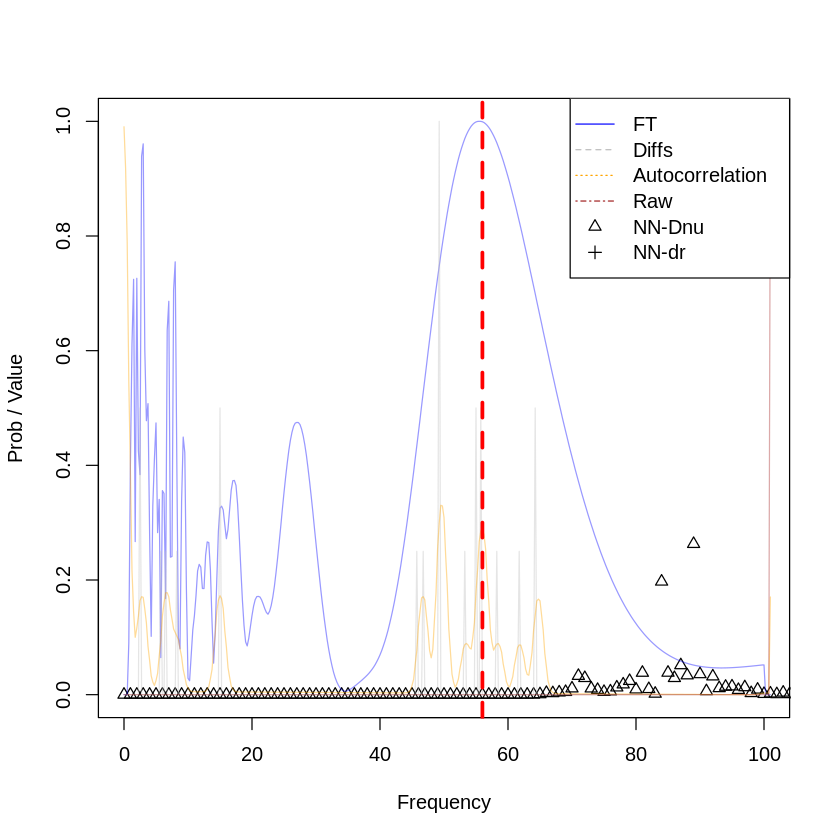

In [181]:
# Quitar las frecuencias < 5 ciclos por día.
d <- read.csv(paste0(stars_base_dir,"CID100866999.lis"), sep="", header=F)
print(paste0("Nrows: ", dim(d)[1]))
head(d)
max <- validate_real_star(d, 56, 0) # There is no information about dr
print(max)
errors <- rbind(errors, data.frame("star"="CID100866999", "difference"=56-max, "n"=dim(d)[1]))

## CID105906206.lis

V1,V2
9.4175,2.552
9.0696,2.296
10.7776,2.150
5.6119,1.160
8.9203,0.906
0.1192,0.880


[1] "Nrows: 202"
  [1] 108.9988426 104.9722222 124.7407407  64.9525463 103.2442130   1.3796296
  [7] 109.6215278 139.7372685 106.6585648  67.5752315 118.2314815   1.6979167
 [13]  90.5000000  97.2638889 143.0219907  62.5000000 146.2800926 110.1481481
 [19]  77.4652778  64.3310185 171.7233796  72.7453704 148.2430556 136.6932870
 [25] 122.2534722 107.7048611 121.5972222  65.6550926 151.3657407 100.2997685
 [31]   3.4282407 175.9548611 113.9722222 169.3460648 102.0983796 174.5879630
 [37] 150.3287037  75.3437500 178.1365741 173.0983796  98.1203704 125.5590278
 [43]  22.2418981   5.3298611 213.6030093 167.9976852 137.5914352 148.7337963
 [49]  61.8923611  84.9664352 210.3564815   9.2905093 145.6412037 219.1412037
 [55]  71.0613426 215.8263889 116.6354167  24.2164352 186.8854167 105.9097222
 [61] 112.3761574   0.4525463  92.3912037  82.7245370 131.4861111 185.7349537
 [67] 208.1932870  81.8831019  78.1956019  91.4293981 166.6053241 135.0023148
 [73]   6.9699074 230.5567130   2.8206019 116.2

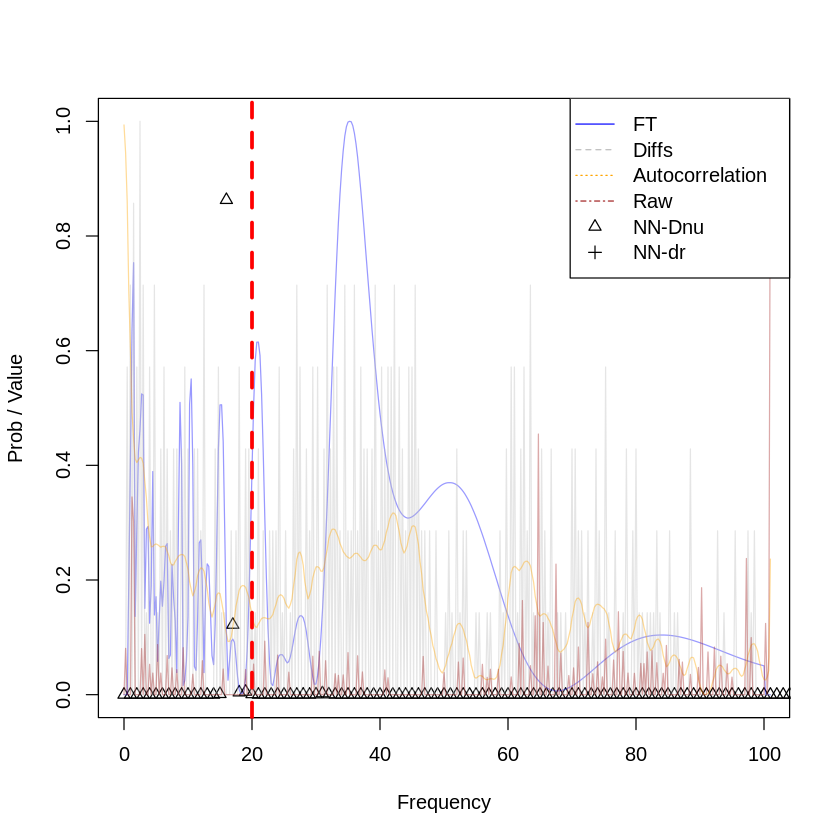

In [182]:
d <- read.csv(paste0(stars_base_dir,"CID105906206.lis"), sep="", header=F)
head(d)
print(paste0("Nrows: ", dim(d)[1]))
max <- validate_real_star(d, 20, 2.61)
errors <- rbind(errors, data.frame("star"="CID105906206", "difference"=20-max, "n"=dim(d)[1]))

## HD15082.lis

V1,V2
20.163899,0.05826439
9.842703,0.05056994
21.064683,0.04185181
1.901497,0.04169184
14.207774,0.04024543
1.028524,5.41987344


[1] "Nrows: 71"
 [1]  233.378465  113.920178  243.804206   22.008062  164.441825   11.904215
 [7]  237.740992  328.574869  821.494541  394.961313   11.189384   28.921603
[13]  288.037943  114.804766   24.191552  100.122313   13.676019   11.905800
[19]    9.452290   87.143738  115.727094  123.065650  321.641178  222.280994
[25]  985.756341  997.271115  136.028823   10.549174    5.938437  109.547258
[31]   89.969729 1150.028948  242.751702    3.983098   12.601073   56.946228
[37]   96.004726  132.914765  231.019669  123.451890  120.072292   77.489356
[43]  492.672981 1161.567861    7.362696   10.066374    5.479777  680.264814
[49]  268.533208   18.998169  492.238461   23.560627  656.535208    2.631259
[55]   91.900928   70.681880   79.372275  157.561691  167.507365  335.545810
[61]  105.950400  118.648033    2.051899  137.187542   43.814075   14.146032
[67]  124.852009    7.917916   50.235312  798.309348  126.831488
[1] "Max hist diff:6"
[1] "Mas acutocorre:1"
[1] "Max raw:5.419873443"


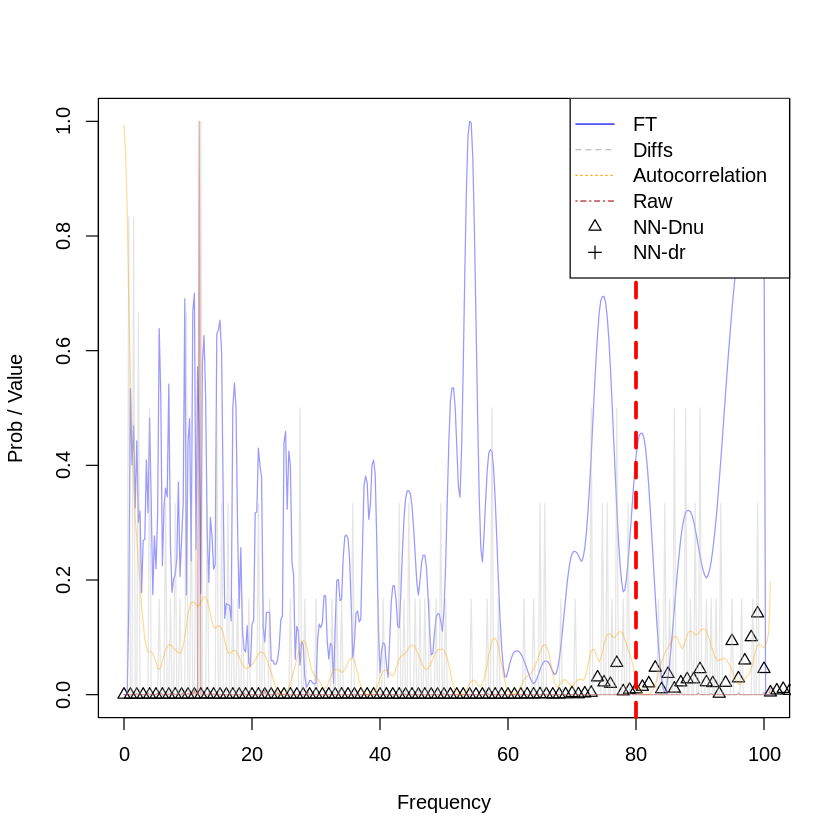

In [183]:
d <- read.csv(paste0(stars_base_dir,"HD15082.lis"), sep="", header=F)
head(d)
print(paste0("Nrows: ", dim(d)[1]))
max <- validate_real_star(d, 80, 14)
errors <- rbind(errors, data.frame("star"="HD15082", "difference"=80-max, "n"=dim(d)[1]))

## HD159561.lis

V1,V2
10.227,0.091
10.469,0.104
10.619,0.243
11.720,0.405
13.096,0.144
16.124,0.349


[1] "Nrows: 40"
 [1] 118.3681 121.1690 122.9051 135.6481 151.5741 186.6204 187.1991 198.8773
 [9] 210.7523 216.0648 217.8009 222.8241 230.7407 234.1204 234.7917 236.3426
[17] 237.4074 251.3079 256.4236 257.0023 260.1852 273.5069 275.5440 284.5139
[25] 291.2731 292.2454 294.1667 296.6782 312.5116 337.0370 339.1667 358.5648
[33] 360.3009 381.3542 398.0556 413.4028 415.2431 458.2986 501.0648 559.5718
[1] "Max hist diff:2"
[1] "Mas acutocorre:1"
[1] "Max raw:0.655"


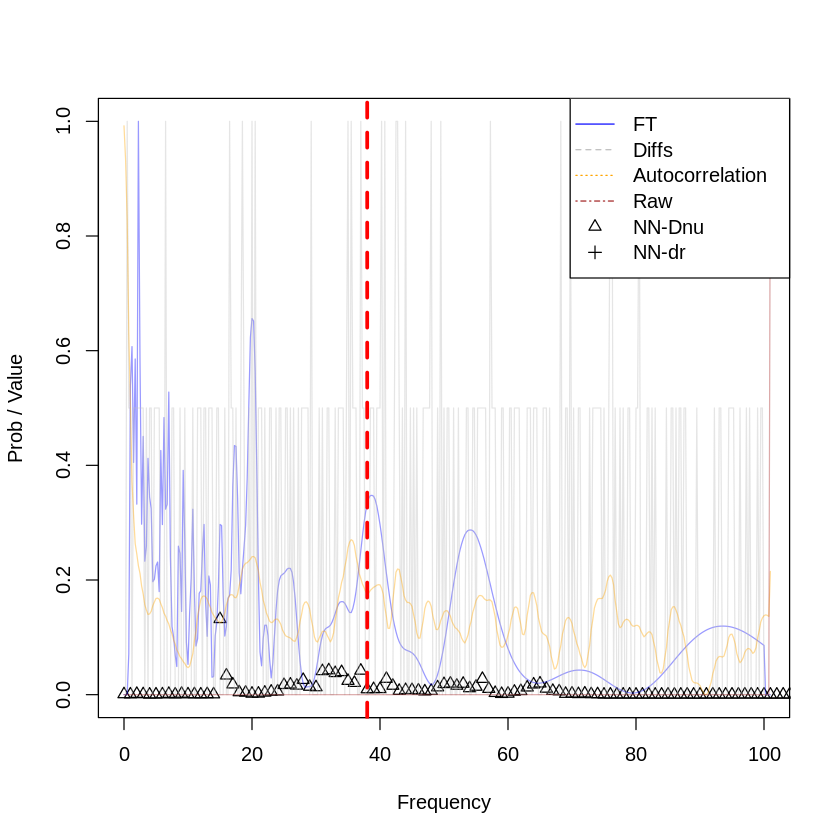

In [184]:
d <- read.csv(paste0(stars_base_dir,"HD159561.lis"), sep="", header=F)
head(d)
print(paste0("Nrows: ", dim(d)[1]))
max <- validate_real_star(d, 38, 19)
errors <- rbind(errors, data.frame("star"="HD159561", "difference"=38-max, "n"=dim(d)[1]))

## HD172189.lis

V1,V2
19.58317,4.513889e-05
17.32212,7.523148e-05
17.94392,7.754630e-05
17.84847,7.986111e-05
19.47873,8.333333e-05
18.02352,1.053241e-04


[1] "Nrows: 50"
 [1] 226.657079 200.487523 207.684237 206.579525 225.448287 208.605510
 [7] 207.160905 197.011618 217.904054 218.539052 215.805363 177.693194
[13] 180.442755 215.280199 213.250385 210.174522 206.264000 178.421859
[19] 200.180878 226.023623 282.757377 234.137841 197.534931 214.699183
[25]   3.909212 188.558494 205.263648 237.510030 266.097676 175.113446
[31] 171.585887 227.990027 183.786576 201.067825 237.643515 215.462542
[37] 203.101046 226.419013 242.794227 174.555140 180.249837 176.521685
[43] 206.119639 275.388546 223.987291 227.356498 282.590501 147.224156
[49] 271.171745 175.784267
[1] "Max hist diff:3"
[1] "Mas acutocorre:1"
[1] "Max raw:0.00124074074074074"


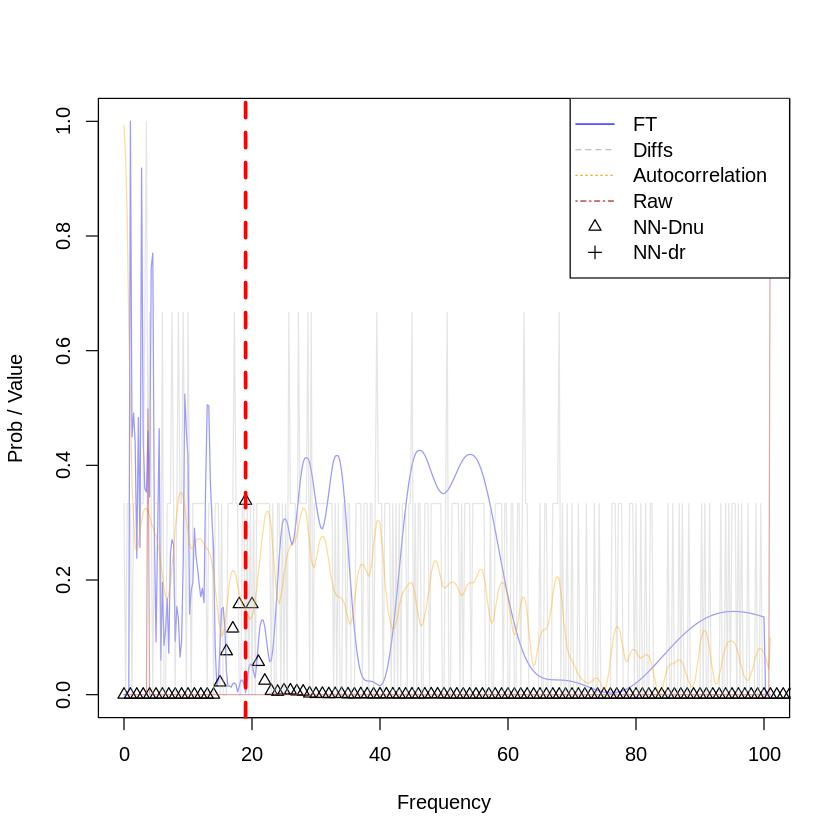

In [185]:
d <- read.csv(paste0(stars_base_dir,"HD172189.lis"), sep="", header=F)
head(d)
print(paste0("Nrows: ", dim(d)[1]))


max <- validate_real_star(d, 19, 4.6)
errors <- rbind(errors, data.frame("star"="HD172189", "difference"=19-max, "n"=dim(d)[1]))

## KIC10080943.lis

V1,V2
13.94759,1360.9
3.33350,1321.8
15.68333,1241.7
12.45258,931.5
12.89054,758.4
17.30504,616.1


[1] "Nrows: 321"
[1] "Max hist diff:265"
[1] "Mas acutocorre:1"
[1] "Max raw:1360.9"


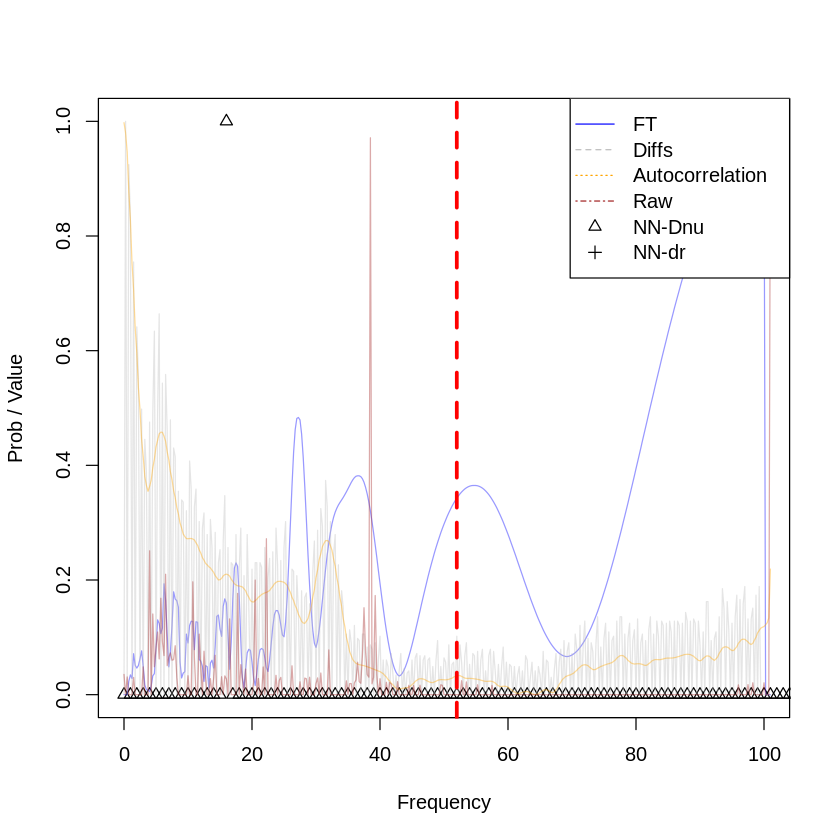

In [197]:
d <- read.csv(paste0(stars_base_dir,"KIC10080943.lis"), sep="", header=F)
head(d)
print(paste0("Nrows: ", dim(d)[1]))
max <- validate_real_star(d, 52, 1.7)
errors <- rbind(errors, data.frame("star"="KIC10080943", "difference"=52-max, "n"=dim(d)[1]))

## kic10661783.lis

V1,V2
28.134,3.07
22.338,3.56
29.383,2.67
25.902,2.02
27.810,0.91
24.407,2.34


[1] "Nrows: 12"
 [1] 325.6250 258.5417 340.0810 299.7917 321.8750 282.4884 331.7014 243.2870
 [9] 294.3056 298.7037 638.1250 607.2106
[1] "Max hist diff:1"
[1] "Mas acutocorre:1"
[1] "Max raw:3.56"


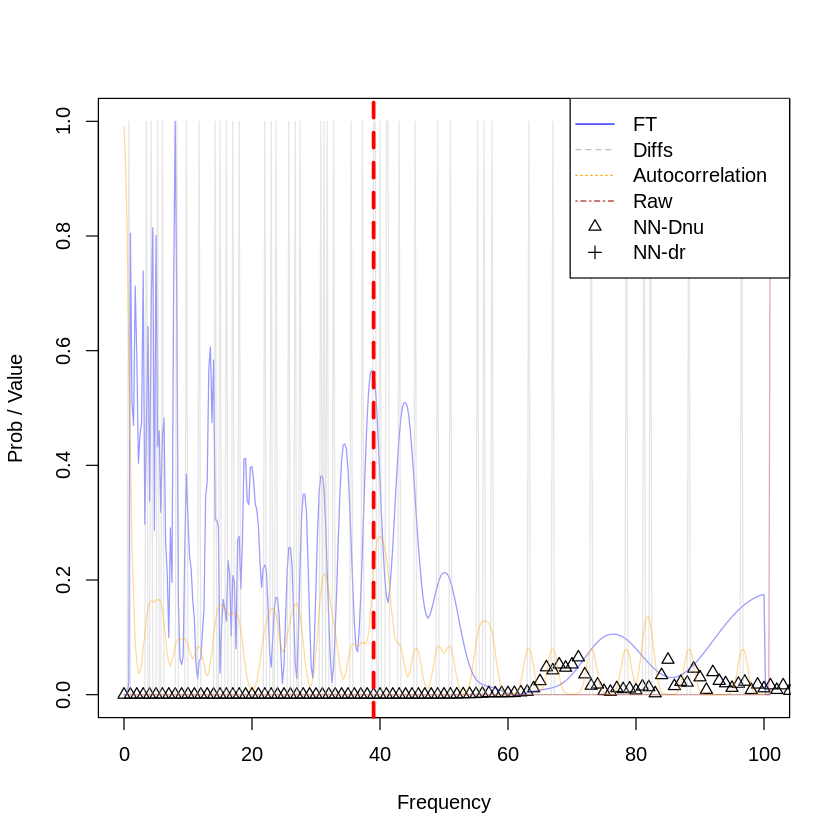

In [187]:
d <- read.csv(paste0(stars_base_dir,"kic10661783.lis"), sep="", header=F)
head(d)
print(paste0("Nrows: ", dim(d)[1]))
max <- validate_real_star(d, 39, 7)
errors <- rbind(errors, data.frame("star"="kic10661783", "difference"=39-max, "n"=dim(d)[1]))

## KIC3858884.lis

V1,V2
7.2306,10.15
7.4734,9.10
9.8376,1.96
7.5125,1.75
6.7358,1.55
9.5191,1.24


[1] "Nrows: 400"
[1] "Max hist diff:14"
[1] "Mas acutocorre:1"
[1] "Max raw:10.15"


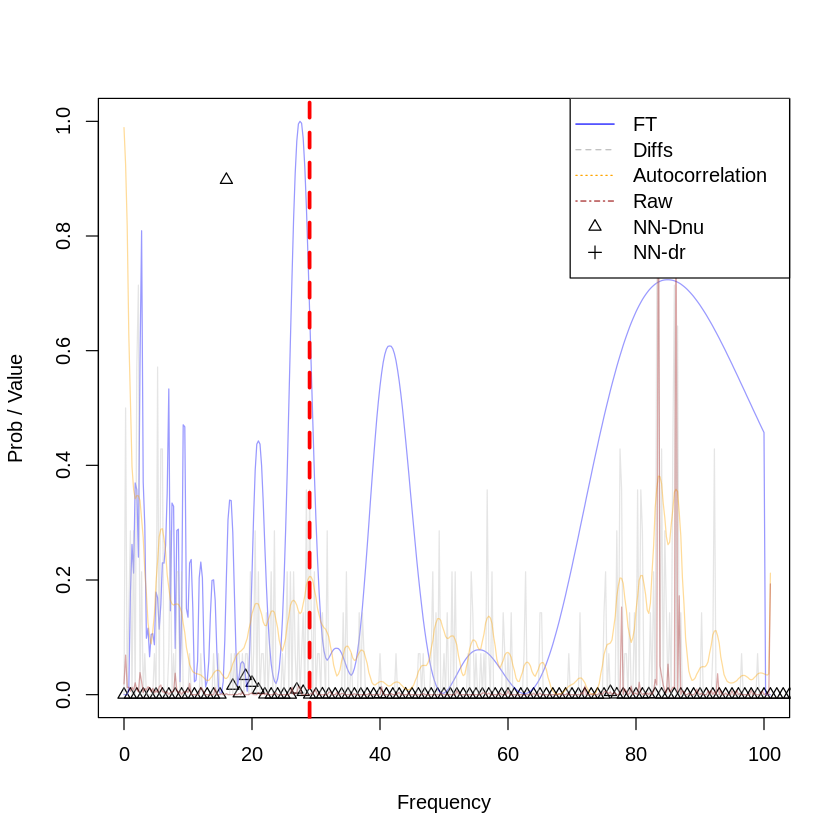

In [198]:
d <- read.csv(paste0(stars_base_dir,"KIC3858884.lis"), sep="", header=F)
head(d)
print(paste0("Nrows: ", dim(d)[1]))
max <- validate_real_star(d, 29, 1.9)
errors <- rbind(errors, data.frame("star"="KIC3858884", "difference"=29-max, "n"=dim(d)[1]))

## kic4544587.lis

V1,V2
48.02231,0.329
41.37020,0.236
44.84695,0.181
46.19662,0.152
48.04449,0.122
39.54280,0.106


[1] "Nrows: 16"
 [1] 555.8138 478.8218 519.0619 534.6831 556.0705 457.6713 502.8653 518.7264
 [9] 539.1597 442.4384 512.7201 513.4396 463.5847 540.2084 518.0137 555.0200
[1] "Max hist diff:5"
[1] "Mas acutocorre:1"
[1] "Max raw:0.329"


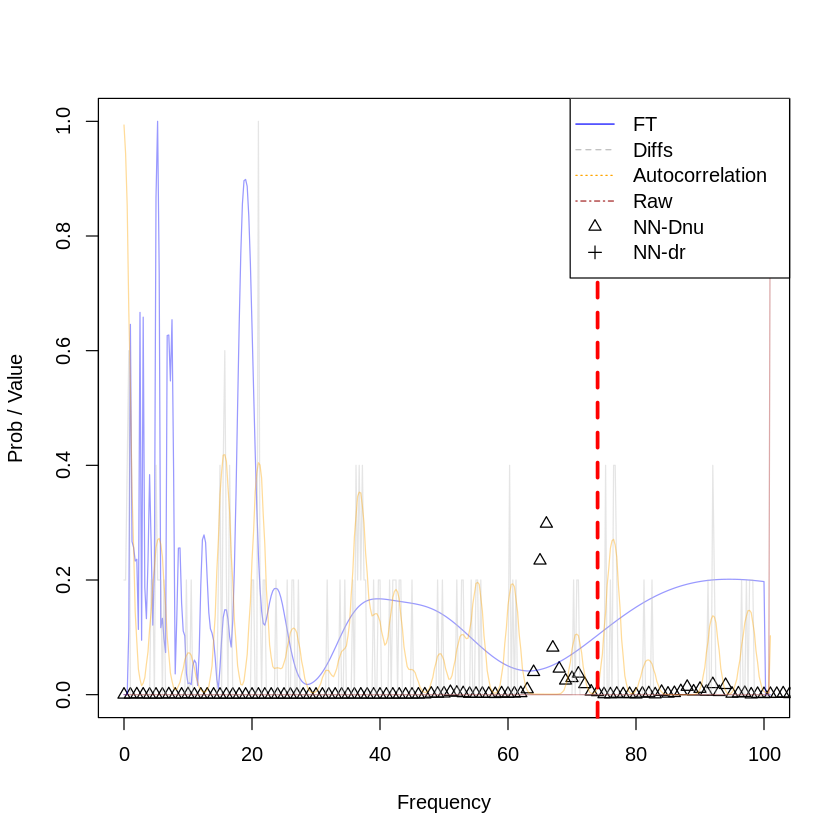

In [189]:
d <- read.csv(paste0(stars_base_dir,"kic4544587.lis"), sep="", header=F)
head(d)
print(paste0("Nrows: ", dim(d)[1]))
max <- validate_real_star(d, 74, 11)
errors <- rbind(errors, data.frame("star"="kic4544587", "difference"=74-max, "n"=dim(d)[1]))

## KIC8262223.lis

V1,V2
64.43390,1.319
57.17794,0.918
61.43616,0.782
53.64792,0.620
51.04548,0.565
54.78183,0.540


[1] "Nrows: 60"
 [1] 745.762731 661.781713 711.066667 620.925000 590.804167 634.048958
 [7] 732.458218 698.063079 708.317477 568.060995 696.678472 738.679051
[13] 635.252894 722.605208 619.680787 668.704861 582.456250 647.453819
[19] 590.021528 746.224306 712.431250 711.347569 676.169907 736.913079
[25] 576.970718 676.209954 697.200231 683.976042 655.380324 697.782176
[31] 746.866435 605.051852 583.660301 630.838194 731.515046 658.069329
[37] 691.742014 668.403819 713.213773 698.705324 591.134838 745.480208
[43] 710.203704 760.028819 775.059144 629.351505 591.656597 696.317245
[49] 698.424306 682.629861 645.988889 672.959144 692.181829   9.250926
[55] 628.308102 555.977199 690.235301 720.536690 751.219329 760.650926
[1] "Max hist diff:7"
[1] "Mas acutocorre:1"
[1] "Max raw:1.319"


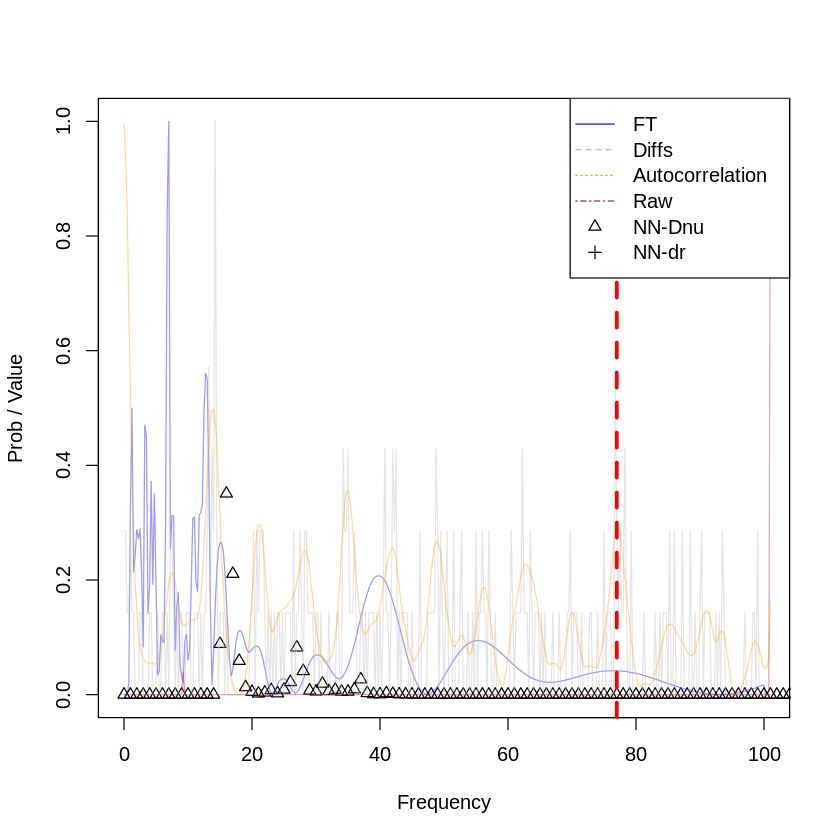

In [190]:
d <- read.csv(paste0(stars_base_dir,"KIC8262223.lis"), sep="", header=F)
head(d)
print(paste0("Nrows: ", dim(d)[1]))
max <- validate_real_star(d, 77, 7.2)
errors <- rbind(errors, data.frame("star"="KIC8262223", "difference"=77-max, "n"=dim(d)[1]))

## KIC9851944.lis

V1,V2
10.399692,0.6530
10.176019,0.5480
11.890476,0.4540
5.097099,0.4046
11.018543,0.2290
12.814916,0.2232


[1] "Nrows: 52"
 [1] 120.36681 117.77800 137.62125  58.99420 127.52943 148.32079 165.68377
 [8]  25.92245 133.36007 132.17373 167.22315  15.01146  26.84861 221.37396
[15]  14.67674  83.64259  58.98808  80.23785  76.27326 224.85891  42.78981
[22]  25.49676  24.70359  59.00093  13.15475 127.37662  55.38356 162.16377
[29] 166.64375  98.97211 130.46736 117.67130 164.47743 199.97917 136.41296
[36] 167.74479 132.38576 142.96713 121.58322 132.27778 241.01273 120.37222
[43] 111.02141 131.54132 267.43553 157.52350 164.36956 171.67303 170.07350
[50] 246.04074 249.11505 245.90139
[1] "Max hist diff:5"
[1] "Mas acutocorre:1"
[1] "Max raw:0.653"


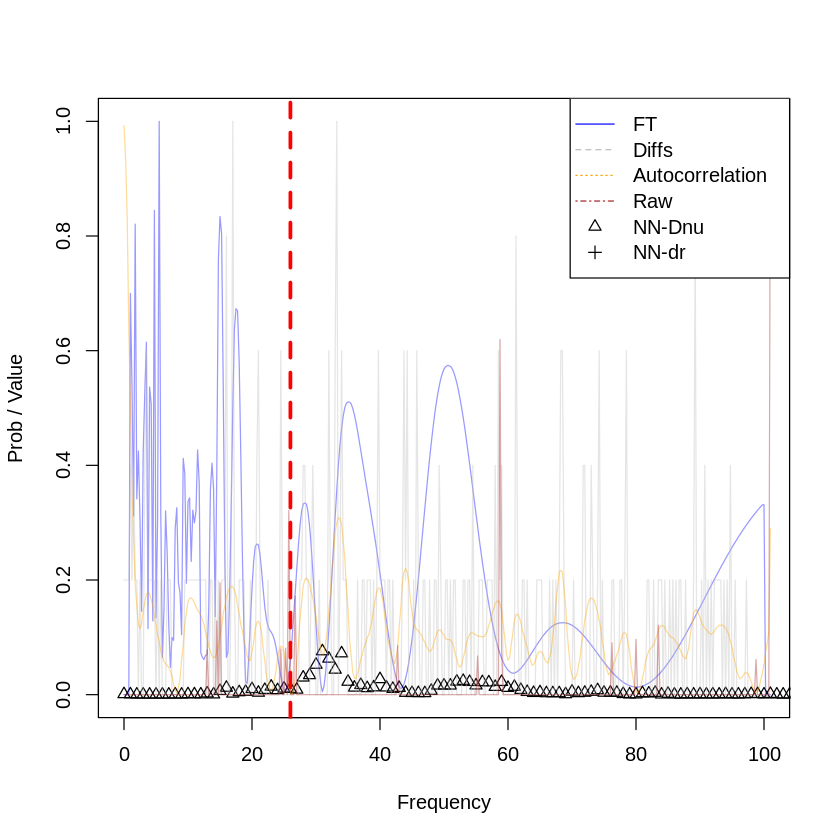

In [191]:
d <- read.csv(paste0(stars_base_dir,"KIC9851944.lis"), sep="", header=F)
head(d)
print(paste0("Nrows: ", dim(d)[1]))
max <- validate_real_star(d, 26, 5.3)
errors <- rbind(errors, data.frame("star"="KIC9851944", "difference"=26-max, "n"=dim(d)[1]))

## All errors

In [192]:
errors
mean(errors$difference)
mean((errors$difference)^2)

star,difference,n
CID100866999,-34,8
CID105906206,3,202
HD15082,-20,71
HD159561,22,40
HD172189,-1,50
KIC10080943,35,321
kic10661783,-33,12
KIC3858884,12,400
kic4544587,7,16
KIC8262223,60,60


[1] 4.090909

[1] 744.8182

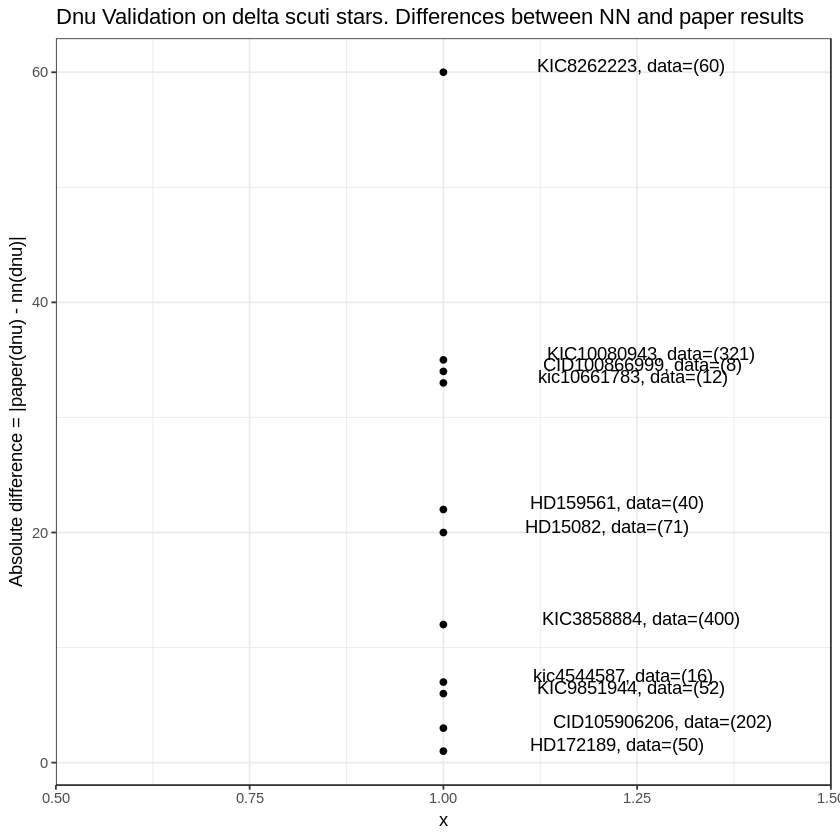

In [193]:
ggplot(aes(y=abs(difference), x=1), data=errors) +
    geom_point() +
    geom_text(aes(label=paste0(star,", data=(",n,")")),hjust=-0.5, vjust=0) +
    ggtitle("Dnu Validation on delta scuti stars. Differences between NN and paper results") +
    ylab("Absolute difference = |paper(dnu) - nn(dnu)|") +
    theme_bw()

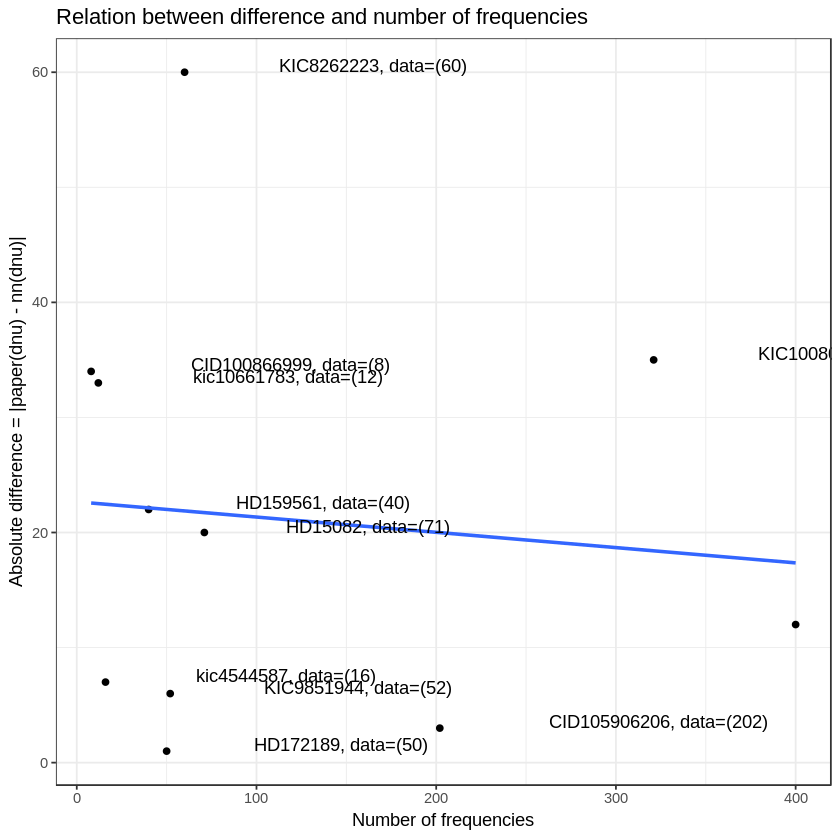

In [194]:
ggplot(aes(y=abs(difference), x=n), data=errors) +
    geom_point()  +
     stat_smooth(method="lm", se=F) +
     geom_text(aes(label=paste0(star,", data=(",n,")")),hjust=-0.5, vjust=0) +
     ggtitle("Relation between difference and number of frequencies") +
     ylab("Absolute difference = |paper(dnu) - nn(dnu)|") +
     xlab("Number of frequencies") +
     theme_bw()